In [94]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
import numpy as np
data = np.load('/Users/anushka/Documents/Summer-Project-/dataset/labeled_embeddings_probs_and_labels_v2.npz')
#show the keys in the file
print(data.files)
embeddings = data['test_embeddings']
print("shape of embeddings:" , embeddings.shape)
probs= data['probs']
print("shape of probs:", probs.shape)
y_labels = data['y_labels']
print("Shape of labels:", y_labels.shape)
y_true = data['y_train']
print("Shape of y_true:", y_true.shape)


['test_embeddings', 'y_train', 'y_labels', 'audio_num', 'probs', 'audio_names']
shape of embeddings: (5702, 64)
shape of probs: (5702, 12)
Shape of labels: (5702,)
Shape of y_true: (5702, 12)


In [95]:
# import random
# import numpy as np
# import torch

# def seed_everything(seed=42):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)

#     # For full reproducibility (slightly slower)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# seed_everything(42)


predicted class : [ 1 11  9 ... 11  9  1]
predicted probabilities : [0.544058   0.97347754 0.7518662  ... 0.96628433 0.9899086  0.9475812 ]
true class : [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]]
true class probabilities : [0.4308202  0.97347754 0.23816009 ... 0.96628433 0.98990858 0.94758117]
true class labels : [ 8 11 11 ... 11  9  1]
tcp_star_targets shape: [0.33793047 1.         0.18461646 ... 1.         1.         1.        ]


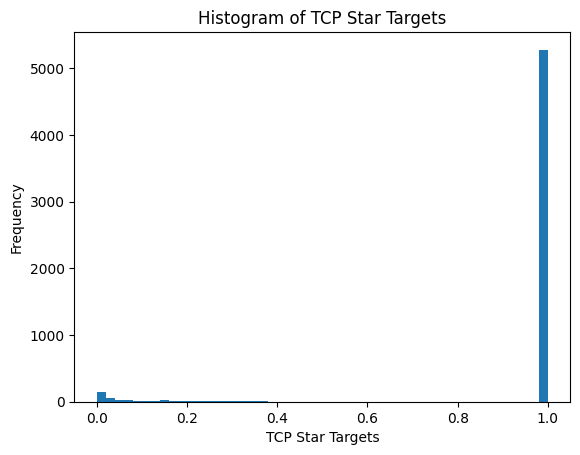

In [96]:
y_hat = np.argmax(probs, axis=1)
print("predicted class :", y_hat)
p_y_hat = np.max(probs, axis=1)
print("predicted probabilities :", p_y_hat)

#True class one hot matrix
y_star= y_true
print("true class :", y_star)
#Prob of true class
p_y_star = np.sum(probs * y_star, axis=1)
print("true class probabilities :", p_y_star)

#True class labels
y_true_class = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true
print("true class labels :", y_true_class)
def compute_tcp_star_targets(y_true_class, y_hat, p_y_star, p_y_hat, alpha):
    indicator = (y_true_class != y_hat).astype(float)
    numerator = p_y_star
    #denominator = p_y_hat 
    denominator = p_y_hat + (indicator * (p_y_star + alpha))
    tcp_star_targets = numerator / denominator
    return tcp_star_targets

tcp_star_targets = compute_tcp_star_targets(y_true_class, y_hat, p_y_star, p_y_hat, alpha=0.3)
print("tcp_star_targets shape:", tcp_star_targets)#plot histogram of tcp_star_targets
import matplotlib.pyplot as plt
plt.hist(tcp_star_targets, bins=50)
plt.xlabel('TCP Star Targets')
plt.ylabel('Frequency')
plt.title('Histogram of TCP Star Targets')
plt.show()
from sklearn.model_selection import train_test_split

X= embeddings
y = tcp_star_targets
from sklearn.model_selection import train_test_split

all_indices = np.arange(len(embeddings))  
train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=42)

# Now use these to split all your arrays
X_train = embeddings[train_indices]
y_train = tcp_star_targets[train_indices]

X_test = embeddings[test_indices]
y_test = tcp_star_targets[test_indices]

# Also for classifier outputs
y_hat_train = y_hat[train_indices]
y_true_class_train = y_true_class[train_indices]
is_correct = (y_hat_train == y_true_class_train)

X_errors = X_train[~is_correct]
y_errors = y_train[~is_correct]

X_success = X_train[is_correct]
y_success = y_train[is_correct]

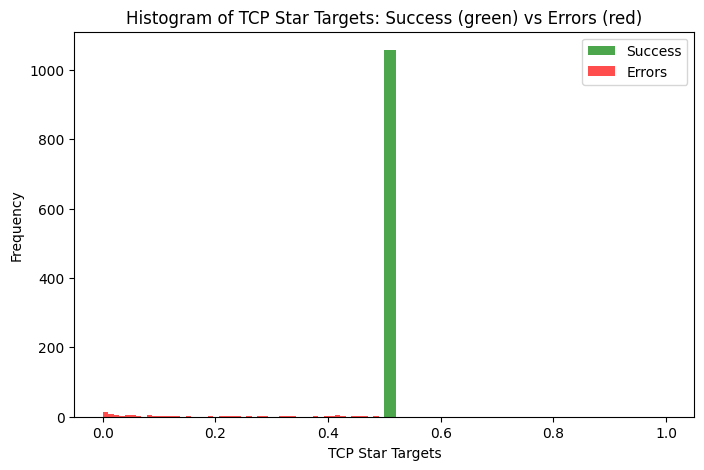

In [97]:
plt.figure(figsize=(8, 5))
plt.hist(y_test_success, bins=50, alpha=0.7, color='green', label='Success')
plt.hist(y_test_errors, bins=50, alpha=0.7, color='red', label='Errors')
plt.xlabel('TCP Star Targets')
plt.ylabel('Frequency')
plt.title('Histogram of TCP Star Targets: Success (green) vs Errors (red)')
plt.legend()
plt.show()


In [98]:
import torch.nn as nn

class ConfidenceNet(nn.Module):
    def __init__(self, input_dim):
        super(ConfidenceNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


In [99]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim import AdamW

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset= TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

input_dim = X_train.shape[1]
output_dim = 1
model = ConfidenceNet(input_dim)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.MSELoss()

# Training the model
for epoch in range(60):
    model.train()
    train_losses=[]
    for xb, yb in train_loader:
        pred=model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1:02d} | Train Loss: {sum(train_losses)/len(train_losses):.6f}")

Epoch 01 | Train Loss: 0.063377
Epoch 02 | Train Loss: 0.047816
Epoch 03 | Train Loss: 0.046476
Epoch 04 | Train Loss: 0.045074
Epoch 05 | Train Loss: 0.044744
Epoch 06 | Train Loss: 0.043289
Epoch 07 | Train Loss: 0.042740
Epoch 08 | Train Loss: 0.042666
Epoch 09 | Train Loss: 0.040668
Epoch 10 | Train Loss: 0.041774
Epoch 11 | Train Loss: 0.040080
Epoch 12 | Train Loss: 0.039536
Epoch 13 | Train Loss: 0.038059
Epoch 14 | Train Loss: 0.039498
Epoch 15 | Train Loss: 0.036807
Epoch 16 | Train Loss: 0.037688
Epoch 17 | Train Loss: 0.035802
Epoch 18 | Train Loss: 0.035629
Epoch 19 | Train Loss: 0.034592
Epoch 20 | Train Loss: 0.034369
Epoch 21 | Train Loss: 0.033813
Epoch 22 | Train Loss: 0.033319
Epoch 23 | Train Loss: 0.034576
Epoch 24 | Train Loss: 0.033589
Epoch 25 | Train Loss: 0.031975
Epoch 26 | Train Loss: 0.031644
Epoch 27 | Train Loss: 0.031370
Epoch 28 | Train Loss: 0.031193
Epoch 29 | Train Loss: 0.030201
Epoch 30 | Train Loss: 0.030588
Epoch 31 | Train Loss: 0.031355
Epoch 32

In [100]:
model.eval()
with torch.no_grad():
    Xall_tensor = torch.tensor(embeddings, dtype=torch.float32)
    confidence_scores_tcpr = model(Xall_tensor).cpu().numpy()  # shape: (1141,)

In [101]:
is_correct_test = y_hat[test_indices] == y_true_class[test_indices]

test_conf = confidence_scores_tcpr[test_indices]
test_y_hat = y_hat[test_indices]
test_y_true = y_true_class[test_indices]

# Only get test set errors
conf_eval_errors = test_conf[~is_correct_test]
y_hat_eval_errors = test_y_hat[~is_correct_test]
y_true_eval_errors = test_y_true[~is_correct_test]

In [102]:
y_hat_test = y_hat[test_indices]  # predicted class from classifier
y_true_test = y_true_class[test_indices]  # true class label

is_correct = (y_hat_test == y_true_test)
conf_correct = test_conf[is_correct]
conf_error = test_conf[~is_correct]

y_hat_correct = y_hat_test[is_correct]
y_hat_error = y_hat_test[~is_correct]

y_true_correct = y_true_test[is_correct]
y_true_error = y_true_test[~is_correct]

is_correct_train = y_hat[train_indices] == y_true_class[train_indices]

train_conf = confidence_scores_tcpr[train_indices]
train_y_hat = y_hat[train_indices]
train_y_true = y_true_class[train_indices]

conf_train_errors = train_conf[~is_correct_train]
conf_train_success = train_conf[is_correct_train]

y_hat_train_errors = train_y_hat[~is_correct_train]
y_hat_train_success = train_y_hat[is_correct_train]

y_true_train_errors = train_y_true[~is_correct_train]
y_true_train_success = train_y_true[is_correct_train]

In [103]:
#Computing ECE
def compute_ECE(confidences, predictions, labels, n_bins=15):
    accuracies = (predictions == labels)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0.0
    total_samples = len(confidences)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        prop_in_bin = np.sum(in_bin) / total_samples

        if np.sum(in_bin) > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += prop_in_bin * np.abs(avg_confidence_in_bin - accuracy_in_bin)

    return ece


In [104]:
import numpy as np
import matplotlib.pyplot as plt

error_counts = []
ece_values = []

# Start config: 200 errors + 4500 successes from training set
max_steps = min(len(conf_eval_errors), 150)  # control based on available eval errors
step = 10

for i in range(0, max_steps + 1, step):
    num_added_errors = i
    num_removed_successes = i

    # Select base set
    train_errors = np.arange(200)  # first 200 errors from training
    train_success = np.arange(len(conf_train_success))
    sample_size = min(4500 - num_removed_successes, len(train_success))
    selected_successes = np.random.choice(train_success, size=sample_size, replace=False)

    # Add i errors from evaluation set
    eval_errors = np.arange(num_added_errors)

    # Final confidence
    conf_subset = np.concatenate([
        conf_train_errors[train_errors],
        conf_train_success[selected_successes],
        conf_eval_errors[eval_errors]
    ])

    y_hat_subset = np.concatenate([
        y_hat_train_errors[train_errors],
        y_hat_train_success[selected_successes],
        y_hat_eval_errors[eval_errors]
    ])

    y_true_subset = np.concatenate([
        y_true_train_errors[train_errors],
        y_true_train_success[selected_successes],
        y_true_eval_errors[eval_errors]
    ])

    # Shuffle
    idx = np.random.permutation(len(conf_subset))
    conf_subset = conf_subset[idx]
    y_hat_subset = y_hat_subset[idx]
    y_true_subset = y_true_subset[idx]

    # Compute ECE
    ece = compute_ECE(conf_subset, y_hat_subset, y_true_subset)
    ece_values.append(ece)
    error_counts.append(200 + i)

    print(f"Errors: {200+i} | Successes: {4500-i} | ECE: {ece:.4f}")

Errors: 200 | Successes: 4500 | ECE: 0.0084
Errors: 210 | Successes: 4490 | ECE: 0.0092
Errors: 220 | Successes: 4480 | ECE: 0.0100
Errors: 230 | Successes: 4470 | ECE: 0.0111
Errors: 240 | Successes: 4460 | ECE: 0.0116
Errors: 250 | Successes: 4450 | ECE: 0.0119
Errors: 260 | Successes: 4440 | ECE: 0.0137
Errors: 270 | Successes: 4430 | ECE: 0.0152
Errors: 280 | Successes: 4420 | ECE: 0.0172


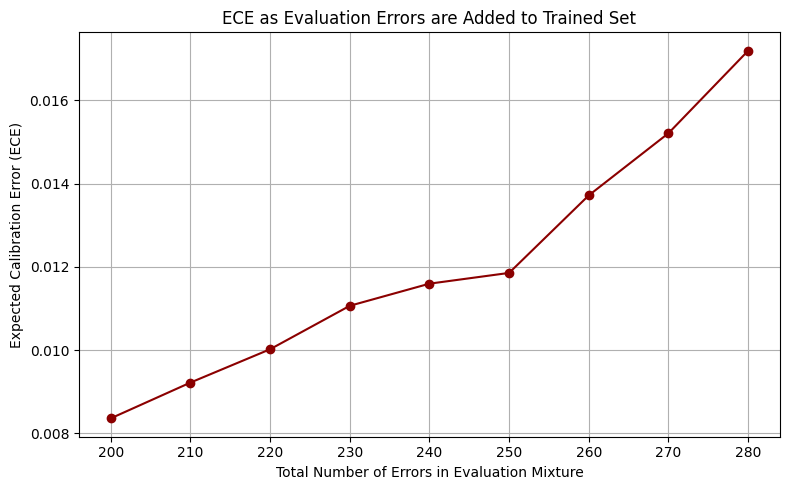

In [105]:
plt.figure(figsize=(8, 5))
plt.plot(error_counts, ece_values, marker='o', color='darkred')
plt.xlabel('Total Number of Errors in Evaluation Mixture')
plt.ylabel('Expected Calibration Error (ECE)')
plt.title('ECE as Evaluation Errors are Added to Trained Set')
plt.grid(True)
plt.tight_layout()
plt.show()